# Credit Risk Prediction With SHAP Analysis

In [19]:
# -------------------------------------------------------
# 1. IMPORT LIBRARIES
# -------------------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [20]:
# -------------------------------------------------------
# 2. LOAD CREDIT-G DATASET FROM OPENML
# -------------------------------------------------------
from sklearn.datasets import fetch_openml
data = fetch_openml('credit-g', version=1, as_frame=True)

df = data.frame
df['class'] = df['class'].map({'good': 0, 'bad': 1})   # convert target

In [21]:
# -------------------------------------------------------
# 3. FEATURE SELECTION
# -------------------------------------------------------
selected_features = [
    'credit_amount',
    'duration',
    'age',
    'checking_status',
    'credit_history',
    'savings_status',
    'employment',
    'installment_commitment',
    'housing',
    'foreign_worker',
    'property_magnitude',
    'existing_credits'
]

X = df[selected_features]
y = df['class']

In [22]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [23]:
# -------------------------------------------------------
# 4. PREPROCESSING PIPELINE
# -------------------------------------------------------
numeric = ['credit_amount', 'duration', 'age', 'installment_commitment', 'existing_credits']
categorical = list(set(selected_features) - set(numeric))

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ]
)

In [24]:
# -------------------------------------------------------
# 5. MODEL TRAINING: XGBOOST & LIGHTGBM
# -------------------------------------------------------

# XGBoost
xgb_model = Pipeline([
    ('pre', preprocess),
    ('clf', xgb.XGBClassifier(
        max_depth=4,
        n_estimators=300,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric='logloss'
    ))
])

In [25]:
# LightGBM
lgb_model = Pipeline([
    ('pre', preprocess),
    ('clf', LGBMClassifier(
        boosting_type='gbdt',
        n_estimators=400,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=31
    ))
])

In [26]:
# Fit models
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 228, number of negative: 522
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304000 -> initscore=-0.828322
[LightGBM] [Info] Start training from score -0.828322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:
# -------------------------------------------------------
# 6. EVALUATE MODELS
# -------------------------------------------------------
def evaluate(model, name):
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"\n{name} Accuracy: {acc:.4f}, F1: {f1:.4f}")
    print(classification_report(y_test, pred))
    return acc, f1

xgb_results = evaluate(xgb_model, "XGBoost")
lgb_results = evaluate(lgb_model, "LightGBM")

best_model = xgb_model if xgb_results[1] > lgb_results[1] else lgb_model
print("\nBest model selected:", "XGBoost" if best_model == xgb_model else "LightGBM")



XGBoost Accuracy: 0.7840, F1: 0.5424
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       178
           1       0.70      0.44      0.54        72

    accuracy                           0.78       250
   macro avg       0.75      0.68      0.70       250
weighted avg       0.77      0.78      0.77       250


LightGBM Accuracy: 0.7880, F1: 0.5827
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       178
           1       0.67      0.51      0.58        72

    accuracy                           0.79       250
   macro avg       0.75      0.71      0.72       250
weighted avg       0.78      0.79      0.78       250


Best model selected: LightGBM


In [42]:
# -------------------------------------------------------
# 8. ROBUST CROSS-VALIDATION
# -------------------------------------------------------
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'pr_auc': make_scorer(average_precision_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# XGBoost CV
xgb_cv_results = cross_validate(
    xgb_model, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

# LightGBM CV
lgb_cv_results = cross_validate(
    lgb_model, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

print("XGBoost CV Scores:")
for metric in scoring.keys():
    print(f"{metric}: {xgb_cv_results[f'test_{metric}'].mean():.4f}")

print("\nLightGBM CV Scores:")
for metric in scoring.keys():
    print(f"{metric}: {lgb_cv_results[f'test_{metric}'].mean():.4f}")

[LightGBM] [Info] Number of positive: 240, number of negative: 560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Info] Number of positive: 228, number of negative: 522
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304000 -> initscore=-0.828322
[LightGBM] [Info] Start training from score -0.828322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

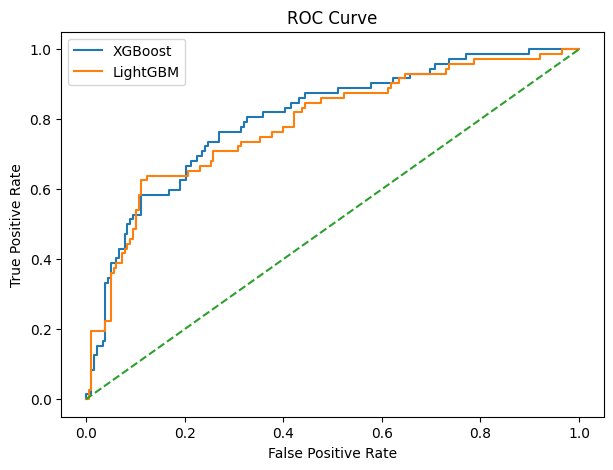

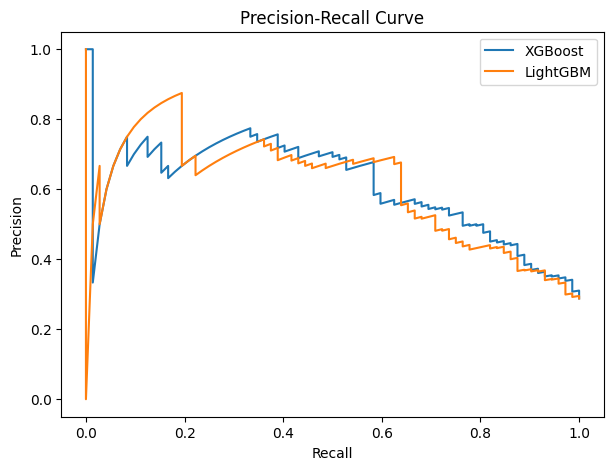

In [43]:
# -------------------------------------------------------
# 9. MODEL EVALUATION
# -------------------------------------------------------
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve, average_precision_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt

# Fit both models
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)[:, 1]

lgb_pred = lgb_model.predict(X_test)
lgb_prob = lgb_model.predict_proba(X_test)[:, 1]

# -------------------------------------------------------
# PRINT METRICS FOR BOTH MODELS
# -------------------------------------------------------

def evaluate_model(name, y_true, y_pred, y_prob):
    print(f"\n===== {name} Evaluation =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print("PR-AUC:", average_precision_score(y_true, y_prob))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

evaluate_model("XGBoost", y_test, xgb_pred, xgb_prob)
evaluate_model("LightGBM", y_test, lgb_pred, lgb_prob)

# -------------------------------------------------------
# PLOTS: ROC CURVE & PRECISION-RECALL CURVE
# -------------------------------------------------------

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot(fpr_lgb, tpr_lgb, label="LightGBM")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, xgb_prob)
prec_lgb, rec_lgb, _ = precision_recall_curve(y_test, lgb_prob)

plt.figure(figsize=(7, 5))
plt.plot(rec_xgb, prec_xgb, label="XGBoost")
plt.plot(rec_lgb, prec_lgb, label="LightGBM")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [49]:
# -------------------------------------------------------
# 10. SHAP EXPLAINABILITY
# -------------------------------------------------------
import shap

# Fit final models again (if not already trained)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Extract the trained booster inside the pipeline
xgb_booster = xgb_model.named_steps['clf']
lgb_booster = lgb_model.named_steps['clf']

# Prepare processed dataset for SHAP
X_train_transformed = xgb_model.named_steps['pre'].transform(X_train)
X_test_transformed = xgb_model.named_steps['pre'].transform(X_test)

# -------------------------------------------------------
# SHAP EXPLAINER (TreeExplainer for tree models)
# -------------------------------------------------------
explainer_xgb = shap.TreeExplainer(xgb_booster)
explainer_lgb = shap.TreeExplainer(lgb_booster)

shap_values_xgb = explainer_xgb.shap_values(X_test_transformed)
shap_values_lgb = explainer_lgb.shap_values(X_test_transformed)

[LightGBM] [Info] Number of positive: 228, number of negative: 522
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 389
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304000 -> initscore=-0.828322
[LightGBM] [Info] Start training from score -0.828322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best


Plotting GLOBAL SHAP Summary (XGBoost)...


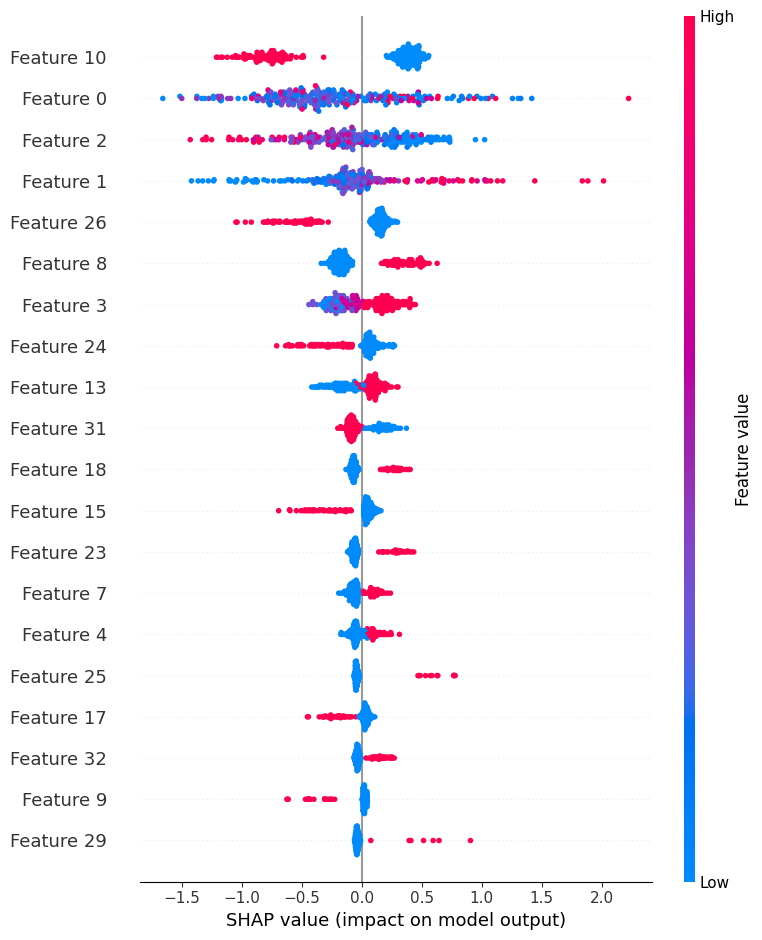


Plotting GLOBAL SHAP Summary (LightGBM)...


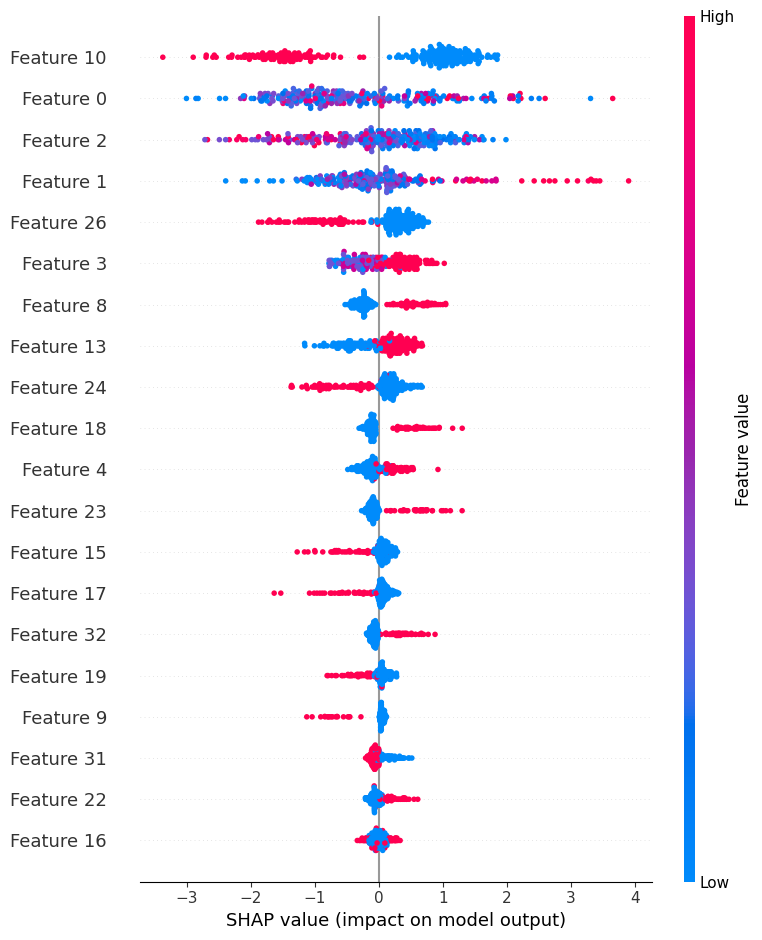

In [50]:
# -------------------------------------------------------
# 1) GLOBAL FEATURE IMPORTANCE
# -------------------------------------------------------
print("\nPlotting GLOBAL SHAP Summary (XGBoost)...")
shap.summary_plot(shap_values_xgb, X_test_transformed, show=True)

print("\nPlotting GLOBAL SHAP Summary (LightGBM)...")
shap.summary_plot(shap_values_lgb, X_test_transformed, show=True)



Local Explanation: DEFAULT (XGBoost)


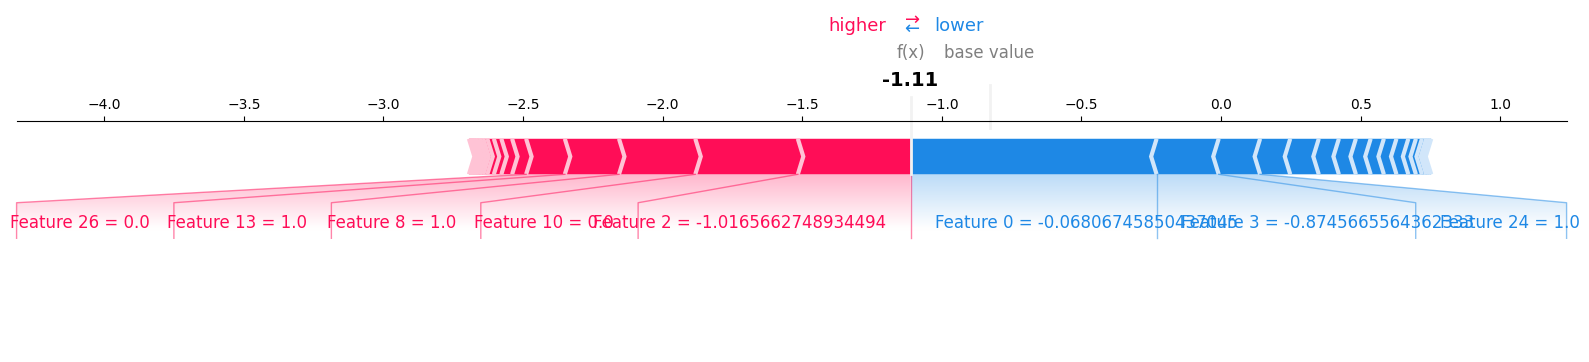


Local Explanation: NON-DEFAULT (XGBoost)


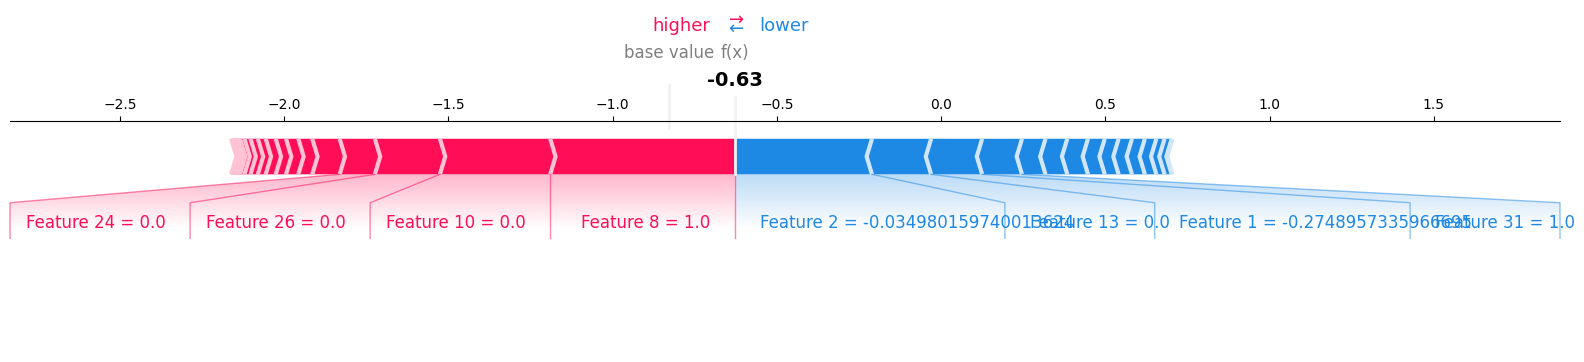

In [55]:
# -------------------------------------------------------
# LOCAL SHAP EXPLANATIONS (FIXED VERSION)
# -------------------------------------------------------

# Find high-stakes predictions
default_index = y_test[y_test == 1].index[0]
non_default_index = y_test[y_test == 0].index[0]

# Extract rows
x_default = X_test.loc[default_index]
x_non_default = X_test.loc[non_default_index]

# IMPORTANT: Convert Series → DataFrame (fixes your error)
x_default_df = pd.DataFrame([x_default])
x_non_default_df = pd.DataFrame([x_non_default])

# Apply preprocessing
x_default_proc = xgb_model.named_steps['pre'].transform(x_default_df)
x_non_default_proc = xgb_model.named_steps['pre'].transform(x_non_default_df)

# SHAP values
sv_default_xgb = explainer_xgb.shap_values(x_default_proc)
sv_non_default_xgb = explainer_xgb.shap_values(x_non_default_proc)

# Local SHAP plots
print("\nLocal Explanation: DEFAULT (XGBoost)")
shap.force_plot(
    explainer_xgb.expected_value,
    sv_default_xgb,
    x_default_proc,
    matplotlib=True
)

print("\nLocal Explanation: NON-DEFAULT (XGBoost)")
shap.force_plot(
    explainer_xgb.expected_value,
    sv_non_default_xgb,
    x_non_default_proc,
    matplotlib=True
)

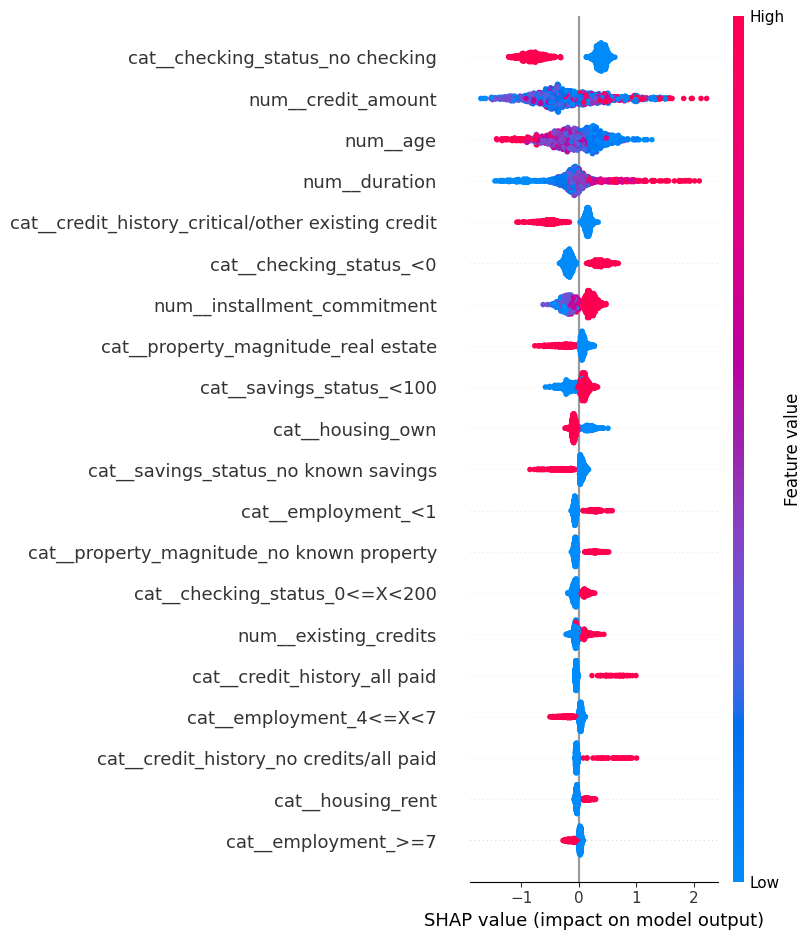

In [58]:
# 1) transform full dataset
X_processed = xgb_model.named_steps['pre'].transform(X)

# 2) SHAP explainer (ONLY model, NOT pipeline)
explainer = shap.TreeExplainer(xgb_model.named_steps['clf'])

# 3) compute SHAP on processed full data
shap_values_xgb = explainer(X_processed)

shap.summary_plot(
    shap_values_xgb.values,
    X_processed,
    feature_names=xgb_model.named_steps['pre'].get_feature_names_out()
)